In [6]:
import logging
import random
import sys

import torch
import transformers
from transformers import AutoModelForCausalLM, set_seed
import ranking


from alignment import (
    DataArguments,
    DPOConfig,
    H4ArgumentParser,
    ModelArguments,
    get_checkpoint,
    get_datasets,
    get_kbit_device_map,
    get_peft_config,
    get_quantization_config,
    get_tokenizer,
    is_adapter_model,
)
from alignment.data import maybe_insert_system_message, is_openai_format
from peft import PeftConfig, PeftModel
from simpo_trainer import SimPOTrainer
from simpo_config import SimPOConfig
from dataclasses import dataclass, field
from typing import Optional, Literal

from trl import DPOTrainer

logger = logging.getLogger(__name__)

MISTRAL_CHAT_TEMPLATE = "{% if messages[0]['role'] == 'system' %}{% set loop_messages = messages[1:] %}{% set system_message = messages[0]['content'].strip() + '\n\n' %}{% else %}{% set loop_messages = messages %}{% set system_message = '' %}{% endif %}{% for message in loop_messages %}{% if loop.index0 == 0 %}{% set content = system_message + message['content'] %}{% else %}{% set content = message['content'] %}{% endif %}{% if message['role'] == 'user' %}{{ '[INST] ' + content.strip() + ' [/INST]' }}{% elif message['role'] == 'assistant' %}{{ ' '  + content.strip() + ' ' + eos_token }}{% endif %}{% endfor %}"

In [2]:
from accelerate import Accelerator
from transformers import HfArgumentParser
from scripts import simpo_config

@dataclass
class CustomDPOConfig(DPOConfig):
    sample: Optional[float] = None
    ranking_type: Optional[Literal["random", "length", "complexity"]] = None

parser = HfArgumentParser((ModelArguments, DataArguments, CustomDPOConfig))
model_args, data_args, simpo_config = parser.parse_yaml_file(yaml_file="training_configs/mistral-7b-base-dpo.yaml")


/data/tillson/conda-envs/simpo/lib/python3.10/site-packages/transformers/training_args.py:1525: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


In [7]:
def apply_chat_template(
    example,
    tokenizer,
    task: Literal["sft", "generation", "rm", "simpo"],
    auto_insert_empty_system_msg: bool = True,
    change_template = None,
):
    if change_template == "mistral":
        tokenizer.chat_template = MISTRAL_CHAT_TEMPLATE
    if task in ["sft", "generation"]:
        messages = example["messages"]
        # We add an empty system message if there is none
        if auto_insert_empty_system_msg:
            maybe_insert_system_message(messages, tokenizer)
        example["text"] = tokenizer.apply_chat_template(
            messages,
            tokenize=False,
            add_generation_prompt=True if task == "generation" else False,
        )
    elif task == "rm":
        if all(k in example.keys() for k in ("chosen", "rejected")):
            chosen_messages = example["chosen"]
            rejected_messages = example["rejected"]
            # We add an empty system message if there is none
            if auto_insert_empty_system_msg:
                maybe_insert_system_message(chosen_messages, tokenizer)
                maybe_insert_system_message(rejected_messages, tokenizer)

            example["text_chosen"] = tokenizer.apply_chat_template(chosen_messages, tokenize=False)
            example["text_rejected"] = tokenizer.apply_chat_template(rejected_messages, tokenize=False)
        else:
            raise ValueError(
                f"Could not format example as dialogue for `rm` task! Require `[chosen, rejected]` keys but found {list(example.keys())}"
            )
    elif task == "simpo":
        if all(k in example.keys() for k in ("chosen", "rejected")):
            if not is_openai_format(example["chosen"]) or not is_openai_format(example["rejected"]):
                raise ValueError(
                    f"Could not format example as dialogue for `{task}` task! Require OpenAI format for all messages"
                )

            # For DPO/ORPO, the inputs are triples of (prompt, chosen, rejected), where `chosen` and `rejected` are the final turn of a dialogue
            # We therefore need to extract the N-1 turns to form the prompt
            if "prompt" in example and is_openai_format(example["prompt"]):
                prompt_messages = example["prompt"]
                chosen_messages = example["chosen"]
                rejected_messages = example["rejected"]
            else:
                prompt_messages = example["chosen"][:-1]
                # Now we extract the final turn to define chosen/rejected responses
                chosen_messages = example["chosen"][-1:]
                rejected_messages = example["rejected"][-1:]

            # Prepend a system message if the first message is not a system message
            if auto_insert_empty_system_msg:
                maybe_insert_system_message(prompt_messages, tokenizer)

            example["text_prompt"] = tokenizer.apply_chat_template(prompt_messages, tokenize=False)
            example["text_chosen"] = tokenizer.apply_chat_template(chosen_messages, tokenize=False)
            if example["text_chosen"].startswith(tokenizer.bos_token):
                example["text_chosen"] = example["text_chosen"][len(tokenizer.bos_token):]
            example["text_rejected"] = tokenizer.apply_chat_template(rejected_messages, tokenize=False)
            if example["text_rejected"].startswith(tokenizer.bos_token):
                example["text_rejected"] = example["text_rejected"][len(tokenizer.bos_token):]
        else:
            raise ValueError(
                f"Could not format example as dialogue for `{task}` task! Require either the "
                f"`[chosen, rejected]` or `[prompt, chosen, rejected]` keys but found {list(example.keys())}"
            )
    else:
        raise ValueError(
            f"Task {task} not supported, please ensure that the provided task is one of ['sft', 'generation', 'rm', 'dpo', 'orpo']"
        )
    return example


In [9]:
@dataclass
class CustomDPOConfig(DPOConfig):
    sample: Optional[float] = None
    ranking_type: Optional[Literal["random", "length", "complexity"]] = None

parser = H4ArgumentParser((ModelArguments, DataArguments, CustomDPOConfig))
model_args, data_args, training_args = parser.parse_yaml_file(yaml_file="training_configs/mistral-7b-base-dpo.yaml")

#######
# Setup
#######
logging.basicConfig(
    format="%(asctime)s - %(levelname)s - %(name)s - %(message)s",
    datefmt="%Y-%m-%d %H:%M:%S",
    handlers=[logging.StreamHandler(sys.stdout)],
)
log_level = training_args.get_process_log_level()
logger.setLevel(log_level)
transformers.utils.logging.set_verbosity(log_level)
transformers.utils.logging.enable_default_handler()
transformers.utils.logging.enable_explicit_format()

# Log on each process the small summary:
logger.info(f"Model parameters {model_args}")
logger.info(f"Data parameters {data_args}")
logger.info(f"Training/evaluation parameters {training_args}")

# Check for last checkpoint
last_checkpoint = get_checkpoint(training_args)
if last_checkpoint is not None and training_args.resume_from_checkpoint is None:
    logger.info(f"Checkpoint detected, resuming training at {last_checkpoint=}.")

# Set seed for reproducibility
set_seed(training_args.seed)

###############
# Load datasets
###############
raw_datasets = get_datasets(
    data_args,
    splits=data_args.dataset_splits,
    configs=data_args.dataset_configs,
    columns_to_keep=["messages", "chosen", "rejected", "prompt", "completion", "label"],
    # seed=training_args.seed,
)
column_names = list(raw_datasets["train"].features)


if training_args.ranking_type == "random":
    raw_datasets = ranking.get_shuffled_dataset(raw_datasets)
elif training_args.ranking_type == "length":
    raw_datasets = ranking.get_length_sorted(raw_datasets)
elif training_args.ranking_type == "complexity":
    raw_datasets = ranking.get_complexity_sorted(raw_datasets)

logger.info(
    f"Training on the following splits: {[split + ' : ' + str(dset.num_rows) for split, dset in raw_datasets.items()]}"
)
logger.info(
    f"Training with ranking type: {training_args.ranking_type}"
)


#####################################
# Load tokenizer and process datasets
#####################################
data_args.truncation_side = "left"  # Truncate from left to ensure we don't lose labels in final turn
tokenizer = get_tokenizer(model_args, data_args)

if "mistral" in model_args.model_name_or_path.lower():
    change_template = "mistral"
else:
    change_template = None
#####################
# Apply chat template
#####################
raw_datasets = raw_datasets.map(
    apply_chat_template,
    fn_kwargs={
        "tokenizer": tokenizer,
        "task": "simpo",
        "auto_insert_empty_system_msg": data_args.auto_insert_empty_system_msg,
        "change_template": change_template,
    },
    num_proc=data_args.preprocessing_num_workers,
    remove_columns=column_names,
    desc="Formatting comparisons with prompt template",
)

# Replace column names with what TRL needs, text_chosen -> chosen and text_rejected -> rejected
for split in ["train", "test"]:
    raw_datasets[split] = raw_datasets[split].rename_columns(
        {"text_prompt": "prompt", "text_chosen": "chosen", "text_rejected": "rejected"}
    )

# Log a few random samples from the training set:
for index in random.sample(range(len(raw_datasets["train"])), 3):
    logger.info(f"Prompt sample {index} of the raw training set:\n\n{raw_datasets['train'][index]['prompt']}")
    logger.info(f"Chosen sample {index} of the raw training set:\n\n{raw_datasets['train'][index]['chosen']}")
    logger.info(f"Rejected sample {index} of the raw training set:\n\n{raw_datasets['train'][index]['rejected']}")

torch_dtype = (
    model_args.torch_dtype if model_args.torch_dtype in ["auto", None] else getattr(torch, model_args.torch_dtype)
)
quantization_config = get_quantization_config(model_args)

model_kwargs = dict(
    revision=model_args.model_revision,
    trust_remote_code=model_args.trust_remote_code,
    torch_dtype=torch_dtype,
    use_cache=False if training_args.gradient_checkpointing else True,
    device_map=get_kbit_device_map() if quantization_config is not None else None,
    quantization_config=quantization_config,
    attn_implementation=model_args.attn_implementation,
)

model = model_args.model_name_or_path
# seems to require internet
# if is_adapter_model(model, model_args.model_revision) is True:
#     logger.info(f"Loading SFT adapter for {model_args.model_name_or_path=}")
#     peft_config = PeftConfig.from_pretrained(model_args.model_name_or_path, revision=model_args.model_revision)
#     model_kwargs = dict(
#         revision=model_args.base_model_revision,
#         trust_remote_code=model_args.trust_remote_code,
#         use_flash_attention_2=model_args.use_flash_attention_2,
#         torch_dtype=torch_dtype,
#         use_cache=False if training_args.gradient_checkpointing else True,
#         device_map=get_kbit_device_map() if quantization_config is not None else None,
#         quantization_config=quantization_config,
#     )
#     base_model = AutoModelForCausalLM.from_pretrained(
#         peft_config.base_model_name_or_path,
#         **model_kwargs,
#     )
#     model = PeftModel.from_pretrained(
#         base_model,
#         model_args.model_name_or_path,
#         revision=model_args.model_revision,
#     )
#     model_kwargs = None

training_args.model_init_kwargs = model_kwargs
#########################
# Instantiate SimPO trainer
#########################


2024-12-08 19:50:39 - INFO - __main__ - Model parameters ModelArguments(base_model_revision=None, model_name_or_path='alignment-handbook/zephyr-7b-sft-full', model_revision='main', model_code_revision=None, torch_dtype=None, tokenizer_name_or_path=None, trust_remote_code=False, attn_implementation='flash_attention_2', use_peft=False, lora_r=16, lora_alpha=32, lora_dropout=0.05, lora_target_modules=None, lora_modules_to_save=None, load_in_8bit=False, load_in_4bit=False, bnb_4bit_quant_type='nf4', use_bnb_nested_quant=False, bnb_4bit_quant_storage='uint8')
2024-12-08 19:50:39 - INFO - __main__ - Data parameters DataArguments(chat_template=None, dataset_mixer={'HuggingFaceH4/ultrafeedback_binarized': 1.0}, text_column='text', dataset_splits=['train_prefs', 'test_prefs'], dataset_configs=None, preprocessing_num_workers=8, truncation_side=None, auto_insert_empty_system_msg=True)
2024-12-08 19:50:39 - INFO - __main__ - Training/evaluation parameters CustomDPOConfig(
_n_gpu=2,
accelerator_con

/data/tillson/conda-envs/simpo/lib/python3.10/site-packages/transformers/training_args.py:1525: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


2024-12-08 19:50:43 - INFO - __main__ - Training on the following splits: ['train : 30567', 'test : 2000']
2024-12-08 19:50:43 - INFO - __main__ - Training with ranking type: random


[INFO|tokenization_utils_base.py:2269] 2024-12-08 19:50:43,656 >> loading file tokenizer.model from cache at None
[INFO|tokenization_utils_base.py:2269] 2024-12-08 19:50:43,657 >> loading file tokenizer.json from cache at /home/tillson/.cache/huggingface/hub/models--alignment-handbook--zephyr-7b-sft-full/snapshots/92f9fac4529acacb2c33a35c46917393690c6311/tokenizer.json
[INFO|tokenization_utils_base.py:2269] 2024-12-08 19:50:43,659 >> loading file added_tokens.json from cache at None
[INFO|tokenization_utils_base.py:2269] 2024-12-08 19:50:43,661 >> loading file special_tokens_map.json from cache at /home/tillson/.cache/huggingface/hub/models--alignment-handbook--zephyr-7b-sft-full/snapshots/92f9fac4529acacb2c33a35c46917393690c6311/special_tokens_map.json
[INFO|tokenization_utils_base.py:2269] 2024-12-08 19:50:43,662 >> loading file tokenizer_config.json from cache at /home/tillson/.cache/huggingface/hub/models--alignment-handbook--zephyr-7b-sft-full/snapshots/92f9fac4529acacb2c33a35c469

2024-12-08 19:50:47 - INFO - __main__ - Prompt sample 20952 of the raw training set:

<|system|>
</s>
<|user|>
Can you provide me with information on McCallum's community engagement events?</s>

2024-12-08 19:50:47 - INFO - __main__ - Chosen sample 20952 of the raw training set:

<|assistant|>
Hello there! I'd be happy to help you with information on McCallum's community engagement events!

At McCallum, we believe in giving back to the community and engaging with our residents in meaningful ways. Here are some of the community engagement events that we have planned for the upcoming months:

1. Neighborhood Clean-Up: Join us for our annual neighborhood clean-up event, where we will be picking up litter, pruning trees, and beautifying our community gardens. This is a great opportunity to meet your neighbors and give back to the community.
2. Community Potluck: Come and share a meal with your neighbors at our community potluck. We will provide the tables, chairs, and utensils, while you b

In [13]:
from trl import DPOTrainer
import importlib
importlib.reload(DPOTrainer)

trainer = DPOTrainer(
    model=model,
    args=training_args,
    train_dataset=raw_datasets["train"],
    eval_dataset=raw_datasets["test"],
    tokenizer=tokenizer,
    peft_config=None # get_peft_config(model_args),
)


ImportError: module DPOTrainer not in sys.modules

In [10]:
tokenizer = get_tokenizer(model_args, data_args)

raw_datasets = raw_datasets.map(
    apply_chat_template,
    fn_kwargs={
        "tokenizer": tokenizer,
        "task": "simpo",
        "auto_insert_empty_system_msg": data_args.auto_insert_empty_system_msg,
        "change_template": "mistral",
    },
    num_proc=8,
    remove_columns=column_names,
    desc="Formatting comparisons with prompt template",
)


In [6]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd


def extract_lengths(example):
    return {
        "text_prompt": len(example["text_prompt"]),
        "text_chosen": len(example["text_chosen"]),
        "text_rejected": len(example["text_rejected"]),
    }

dataset_lengths = raw_datasets.map(
    extract_lengths,
    num_proc=8,
    desc="Reducing data entries to lengths for ranking",
)

train_lengths = dataset_lengths["train"]
test_lengths = dataset_lengths["test"]



Reducing data entries to lengths for ranking (num_proc=8):   0%|          | 0/61135 [00:00<?, ? examples/s]


KeyError: 'text_prompt'

In [12]:
import importlib
import ranking
importlib.reload(ranking)

ranking.get_shuffled_dataset(raw_datasets)

Flattening the indices: 100%|██████████| 2000/2000 [00:00<00:00, 29879.49 examples/s]


DatasetDict({
    train: Dataset({
        features: ['text_prompt', 'text_chosen', 'text_rejected'],
        num_rows: 61135
    })
    test: Dataset({
        features: ['text_prompt', 'text_chosen', 'text_rejected'],
        num_rows: 2000
    })
})

In [19]:
raw_datasets

DatasetDict({
    train: Dataset({
        features: ['text_prompt', 'text_chosen', 'text_rejected'],
        num_rows: 61135
    })
    test: Dataset({
        features: ['text_prompt', 'text_chosen', 'text_rejected'],
        num_rows: 2000
    })
})

In [34]:
import importlib
import ranking
importlib.reload(ranking)

ranking.get_shuffled_dataset(raw_datasets)

Flattening the indices: 100%|██████████| 30567/30567 [00:01<00:00, 15413.69 examples/s]


DatasetDict({
    train: Dataset({
        features: ['text_prompt', 'text_chosen', 'text_rejected', 'text_prompt_complexity', 'text_chosen_complexity', 'text_rejected_complexity'],
        num_rows: 30567
    })
    test: Dataset({
        features: ['text_prompt', 'text_chosen', 'text_rejected'],
        num_rows: 2000
    })
})

In [43]:
import importlib
import ranking
importlib.reload(ranking)

ranking.get_length_sorted(raw_datasets)#["train"][0]["text_chosen"]

DatasetDict({
    train: Dataset({
        features: ['text_prompt', 'text_chosen', 'text_rejected', 'text_prompt_complexity', 'text_chosen_complexity', 'text_rejected_complexity'],
        num_rows: 30567
    })
    test: Dataset({
        features: ['text_prompt', 'text_chosen', 'text_rejected'],
        num_rows: 2000
    })
})

In [39]:
import importlib
import ranking
importlib.reload(ranking)

ranking.get_complexity_sorted(raw_datasets)["train"][0]

InvalidParameterError: The 'strip_accents' parameter of TfidfVectorizer must be a str among {'ascii', 'unicode'}, None or a callable. Got True instead.

In [11]:
from sklearn.feature_extraction.text import TfidfVectorizer
import numpy as np

def compute_tfidf_and_complexity(raw_datasets):
    # Combine all text fields from the training set into a single collection
    train_texts = [
        entry["text_prompt"] + " " + entry["text_chosen"] + " " + entry["text_rejected"]
        for entry in raw_datasets["train"]
    ]

    # Fit TF-IDF vectorizer on the training data
    tfidf_vectorizer = TfidfVectorizer(lowercase=True)
    tfidf_vectorizer.fit(train_texts)

    # Precompute useful values
    tfidf_vocab = tfidf_vectorizer.vocabulary_
    idf_values = tfidf_vectorizer.idf_
    lowest_tfidf_value = idf_values.min()

    # Function to compute complexity for a single example
    def compute_complexity_for_example(example):
        def average_tfidf(text):
            tokens = text.split()
            tfidf_scores = [
                idf_values[tfidf_vocab[token]]
                if token in tfidf_vocab
                else lowest_tfidf_value
                for token in tokens
            ]
            return np.mean(tfidf_scores)/len(tokens) if tfidf_scores else lowest_tfidf_value

        return {
            "text_prompt": average_tfidf(example["text_prompt"]),
            "text_chosen": average_tfidf(example["text_chosen"]),
            "text_rejected": average_tfidf(example["text_rejected"]),
        }

    # Map function to both train and test datasets using precomputed TF-IDF data
    train_complexity = raw_datasets["train"].map(
        compute_complexity_for_example,
        num_proc=8,
        desc="Computing complexity for train set"
    )
    test_complexity = raw_datasets["test"].map(
        compute_complexity_for_example,
        num_proc=8,
        desc="Computing complexity for test set"
    )

    return train_complexity, test_complexity


# Call the function to compute complexity
train_complexity, test_complexity = compute_tfidf_and_complexity(raw_datasets)


In [12]:
# idf_values[tfidf_vocab[token]]

In [13]:
# pd.DataFrame(train_complexity)

In [14]:
# lengths_df

In [32]:
# Convert train and test datasets to DataFrame
train_df = pd.DataFrame(train_lengths)
train_df["set"] = "train"
test_df = pd.DataFrame(test_lengths)
test_df["set"] = "test"

# Combine train and test data
lengths_df = pd.concat([train_df, test_df])

# Plot CDFs using subplots for text_prompt, text_chosen, and text_rejected
fig, axes = plt.subplots(2, 3, figsize=(12, 4), sharey=True, constrained_layout=True)
text_types = ["text_prompt", "text_chosen", "text_rejected"]
titles = ["Prompts", "Chosen response", "Rejected response"]

# Plot lengths CDF
for i, text_type in enumerate(text_types):
    sns.ecdfplot(
        data=lengths_df, 
        x=text_type, 
        hue="set", 
        ax=axes[0, i]
    )
    axes[0, i].set_title(titles[i])
    axes[0, i].set_xlabel("")
    axes[0, i].set_ylabel("CDF")
    axes[0, i].set_xscale("log")
    axes[0, i].set_xlim(1, 10**4)

    if i == 2:  # Add 'Length' label to the right
        axes[0, i].annotate(
            "Length", 
            xy=(1.05, 0.5), 
            xycoords='axes fraction', 
            rotation=-90, 
            fontsize=12, 
            ha='center', 
            va='center'
        )

# Convert train and test datasets to DataFrame
train_df = pd.DataFrame(train_complexity)
train_df["set"] = "train"
test_df = pd.DataFrame(test_complexity)
test_df["set"] = "test"

# Combine train and test data
complexity_df = pd.concat([train_df, test_df])

# Plot complexity CDF
for i, text_type in enumerate(text_types):
    sns.ecdfplot(
        data=complexity_df, 
        x=text_type, 
        hue="set", 
        ax=axes[1, i]
    )
    axes[1, i].set_title("")
    axes[1, i].set_xlabel("")
    axes[1, i].set_ylabel("CDF")

    if i == 2:  # Add 'Complexity' label to the right
        axes[1, i].annotate(
            "Complexity", 
            xy=(1.05, 0.5), 
            xycoords='axes fraction', 
            rotation=-90, 
            fontsize=12, 
            ha='center', 
            va='center'
        )

# # Move legend to the right-hand side of the figure
# handles, labels = axes[0, 0].get_legend_handles_labels()
# fig.legend(
#     handles, 
#     labels, 
#     loc="center right", 
#     bbox_to_anchor=(1.15, 0.5), 
#     title="Set", 
#     frameon=False
# )

# Add padding to the left
# plt.subplots_adjust(left=0.1)

# Save or show the plot
plt.savefig("figs/cdf_of_data_with_labels_and_legend.pdf")
plt.show()


NameError: name 'pd' is not defined

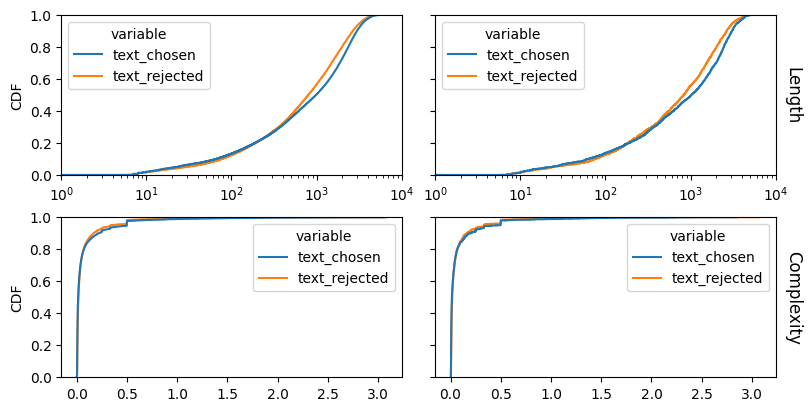

In [16]:
# Convert train and test datasets to DataFrame
train_length_df = pd.DataFrame(train_lengths)
train_length_df["set"] = "train"
test_length_df = pd.DataFrame(test_lengths)
test_length_df["set"] = "test"


train_complexity_df = pd.DataFrame(train_complexity)
train_complexity_df["set"] = "train"
test_complexity_df = pd.DataFrame(test_complexity)
test_complexity_df["set"] = "test"

# test_lengths["set"] = "test"
# train_complexity["set"] = "train"
# test_complexity["set"] = "test"

# Combine lengths and complexity datasets
lengths_df = pd.concat([train_length_df, test_length_df])
lengths_df = lengths_df.melt(id_vars=["set"], value_vars=["text_chosen", "text_rejected"])
complexity_df = pd.concat([train_complexity_df, test_complexity_df])
complexity_df = complexity_df.melt(id_vars=["set"], value_vars=["text_chosen", "text_rejected"])

# Create a 2x2 plot
fig, axes = plt.subplots(2, 2, figsize=(8, 4), sharey=True, constrained_layout=True)

# Plot lengths CDF for training and testing
for i, data_set in enumerate(["train", "test"]):    
    sns.ecdfplot(
        data=lengths_df[lengths_df["set"] == data_set], 
        x="value", 
        hue="variable", 
        ax=axes[0, i]
    )
    axes[0, i].set_title("")
    axes[0, i].set_xlabel("")
    axes[0, i].set_ylabel("CDF" if i == 0 else "")
    axes[0, i].set_xscale("log")
    axes[0, i].set_xlim(1, 10**4)
    # axes[0, i].legend(title="Type", frameon=False)

    if i == 1:  # Add 'Length' label to the right
        axes[0, i].annotate(
            "Length", 
            xy=(1.05, 0.5), 
            xycoords='axes fraction', 
            rotation=-90, 
            fontsize=12, 
            ha='center', 
            va='center'
        )


# Plot complexity CDF for training and testing
for i, data_set in enumerate(["train", "test"]):
    sns.ecdfplot(
        data=complexity_df[complexity_df["set"] == data_set], 
        x="value", 
        hue="variable", 
        ax=axes[1, i]
    )
    axes[1, i].set_title("")
    axes[1, i].set_xlabel("")
    axes[1, i].set_ylabel("CDF" if i == 0 else "")
    # axes[1, i].legend(title="Type", frameon=False)

    if i == 1:  # Add 'Length' label to the right
        axes[1, i].annotate(
            "Complexity", 
            xy=(1.05, 0.5), 
            xycoords='axes fraction', 
            rotation=-90, 
            fontsize=12, 
            ha='center', 
            va='center'
        )


# Save or show the plot
plt.savefig("figs/cdf_of_data_with_train_test_comparison.pdf")
plt.show()


In [17]:
complexity_df

,set,variable,value
0,train,text_chosen,0.012426
1,train,text_chosen,0.045777
2,train,text_chosen,0.020198
3,train,text_chosen,1.528025
4,train,text_chosen,0.028362
...,...,...,...
126265,test,text_rejected,0.007502
126266,test,text_rejected,0.091290
126267,test,text_rejected,0.007833
126268,test,text_rejected,1.079241


In [18]:
lengths_df.groupby(["set", "variable"])["value"].describe()

count         mean          std  min    25%     50%  \
set   variable                                                               
test  text_chosen     2000.0  1340.141000  1193.923822  7.0  288.0  1024.0   
      text_rejected   2000.0  1135.156500  1043.977804  6.0  251.5   831.5   
train text_chosen    61135.0  1301.021346  1168.501140  6.0  277.0   987.0   
      text_rejected  61135.0  1126.544614  1044.744491  6.0  271.0   803.0   

                         75%      max  
set   variable                         
test  text_chosen    2241.50   5209.0  
      text_rejected  1772.25   5108.0  
train text_chosen    2116.00  12609.0  
      text_rejected  1734.00   8267.0

In [19]:
lengths_df.melt(id_vars=["set"], value_vars=["text_chosen", "text_rejected"])

ValueError: value_name (value) cannot match an element in the DataFrame columns.

In [49]:
complexity_df

,set,variable,value
0,train,text_chosen,2.385733
1,train,text_chosen,2.655094
2,train,text_chosen,4.544635
3,train,text_chosen,3.056051
4,train,text_chosen,2.382381
...,...,...,...
126265,test,text_rejected,2.385538
126266,test,text_rejected,2.556126
126267,test,text_rejected,2.491041
126268,test,text_rejected,4.316966


In [20]:
plt.show()

In [47]:
complexity_df

,set,variable,value
0,train,text_chosen,2.385733
1,train,text_chosen,2.655094
2,train,text_chosen,4.544635
3,train,text_chosen,3.056051
4,train,text_chosen,2.382381
...,...,...,...
126265,test,text_rejected,2.385538
126266,test,text_rejected,2.556126
126267,test,text_rejected,2.491041
126268,test,text_rejected,4.316966


In [22]:
# # Convert train and test datasets to DataFrame
# train_df = pd.DataFrame(train_complexity)
# train_df["set"] = "train"
# test_df = pd.DataFrame(test_complexity)
# test_df["set"] = "test"

# Combine train and test data
complexity_df = pd.concat([train_df, test_df])


for i, text_type in enumerate(text_types):
    sns.ecdfplot(
        data=complexity_df, 
        x=text_type, 
        hue="set", 
        ax=axes[1, i]
    )
    axes[1, i].set_title(titles[i])
    axes[1, i].set_xlabel("Length")
    axes[1, i].set_ylabel("CDF")
    # axes[1, i].set_xscale("log")
    # axes[1, i].set_xlim(1, 10**4)



plt.tight_layout()
# plt.show()
# plt.savefig("figs/cdf_of_data.pdf")
plt.show()


<Figure size 640x480 with 0 Axes>

In [23]:
raw_datasets["test"]

Dataset({
    features: ['text_prompt', 'text_chosen', 'text_rejected'],
    num_rows: 2000
})

In [24]:
for x in dataset_lengths["train"]

SyntaxError: expected ':' (2642744887.py, line 1)